# Code for generating plots for Fig. 1, S2, S3ABG, S4B

Run this code sequentially cell by cell.

In [2]:
from matplotlib import pyplot as plt
import os
import numpy as np
from mmpyreader import mmpyreader 
from pycromanager import Bridge
from scipy import interpolate
from scipy.stats import ks_2samp

In [3]:
currdir=os.getcwd()

In [4]:
color_blind=True # set this to False to render images in red and green instead

### define some helper classes for loading shapes and coordinates of the wells:

In [5]:
class Coordinates:
    def __init__(self,name):
        file=open(name)
        file.readline()
        self.shapes = np.array([np.array(list(map(int, line.split(',')))) for line in file])
        file.close()
        print(len(self.shapes))
        print(self.shapes[-1])
        self.shapesraw=self.shapes

        print("removing wells with problems")
        self.shapes=self.shapes[self.shapes[:,4]==0]
        print(len(self.shapes))

        self.T100A20=self.shapes[np.logical_and(self.shapes[:,3]==100,self.shapes[:,2]==20)][:,[0,1]]
        self.T50A20=self.shapes[np.logical_and(self.shapes[:,3]==50,self.shapes[:,2]==20)][:,[0,1]]
        self.T20A20=self.shapes[np.logical_and(self.shapes[:,3]==20,self.shapes[:,2]==20)][:,[0,1]]
        self.T10A20=self.shapes[np.logical_and(self.shapes[:,3]==10,self.shapes[:,2]==20)][:,[0,1]]
        self.T100A10=self.shapes[np.logical_and(self.shapes[:,3]==100,self.shapes[:,2]==10)][:,[0,1]]
        self.T50A10=self.shapes[np.logical_and(self.shapes[:,3]==50,self.shapes[:,2]==10)][:,[0,1]]
        self.T20A10=self.shapes[np.logical_and(self.shapes[:,3]==20,self.shapes[:,2]==10)][:,[0,1]]
        self.T10A10=self.shapes[np.logical_and(self.shapes[:,3]==10,self.shapes[:,2]==10)][:,[0,1]]
        self.flat=self.shapes[self.shapes[:,3]==0][:,[0,1]]
        
        self.TAs=[self.T100A20,self.T100A10,self.T50A20,self.T50A10,self.T20A20,
               self.T20A10,self.flat,self.T10A20,self.T10A10]

In [6]:
# coordinates of wells with different A and T
c1=Coordinates(currdir+'\\data_Fig_1\\experiment_1\\shape_table_20x_2023_11_22.csv')
c2=Coordinates(currdir+'\\data_Fig_1\\experiment_2\\shape_table_2024_01_18_nikon2_bottom_shorter.csv')
c3=Coordinates(currdir+'\\data_Fig_1\\experiment_3\\shape_table_2024_01_26_nikon2_bottom_longer.csv')

240
[ 59   3  10 100   0]
removing wells with problems
236
240
[ 79   2  20 100   0]
removing wells with problems
240
240
[ 79   2  10 100   0]
removing wells with problems
240


## Fig. 1C. snapshots of randomly selected wells

This part can be skipped if there is not need to generate images

In [3]:
# open a bridge to Micromanager. Micromanager must be running a server on port 4827
reader = mmpyreader.MMpyreader()
mm=reader.mm
builder = mm.data().getCoordsBuilder()

In [113]:
stack = reader.load_folder(currdir+"\\data_Fig_1\\experiment_1\\last_frame",True)
axes = stack._metadata.getOrderedAxes()
print(axes)
axnb = list(stack._mmstore.getNextIndex(ax) for ax in axes)
print(axnb)

1T x 60P x 3C x 1Z
['z', 'channel', 'position', 'time']
[1, 3, 60, 1]


In [114]:
pixelsize=0.4172
def get_positions_of_wells(name):
    global pixelsize
    data = np.genfromtxt(name, delimiter=',', skip_header = 1)
    #print(data)
    return (1./pixelsize)*np.reshape(data,(4,4,-1))[:,:,1:3]


def extract_image(pi,ni, ax_array=None,as_array=False,flip_if_required=False):

    poss=get_positions_of_wells("data_Fig_1\\experiment_1\\wells_coordinates\\Results"+str(pi)+".csv")
    if (pi<30):
        x1,y1=poss[ni,0,0]-20,poss[ni,0,1]-70
        x2,y2=poss[ni,2,0]+20,poss[ni,2,1]+70
    else:
        x1,y1=poss[ni,0,0]-20,poss[ni,0,1]-70
        x2,y2=poss[ni,2,0]+20,poss[ni,2,1]+70        

    imgFL1,img_meta = stack.get_img(C=1,P=pi,T=0,Z=0)
    imgFL2,img_meta = stack.get_img(C=2,P=pi,T=0,Z=0)
    imgBR,img_meta = stack.get_img(C=0,P=pi,T=0,Z=0)

    imgFL1=imgFL1.astype(float)
    imgFL1-=imgFL1[int(y1):int(y2),int(x1):int(x2)].min()
    imgFL1/=imgFL1[int(y1):int(y2),int(x1):int(x2)].max()
    imgFL2=imgFL2.astype(float)
    imgFL2-=imgFL2[int(y1):int(y2),int(x1):int(x2)].min()
    imgFL2/=imgFL2[int(y1):int(y2),int(x1):int(x2)].max()
    imgBR=imgBR.astype(float)
    imgBR/=imgBR.max()
    
    imgR=imgFL1
    imgG=imgFL2
    if color_blind:
        imgB=imgR
    else:
        imgB=0.5*imgBR
    
    img=np.dstack((imgR,imgG,imgB))        
    
    if (as_array):
        return imgBR[int(y1):int(y2),int(x1):int(x2)], imgFL1[int(y1):int(y2),int(x1):int(x2)], imgFL2[int(y1):int(y2),int(x1):int(x2)], int(x1), int(y1), int(x2),int(y2)
    if (ax_array==None):
        plt.axis('off')
        if (flip_if_required==True and pi<30):
            plt.imshow(np.flip(img[int(y1):int(y2),int(x1):int(x2)],axis=0))
        else:
            plt.imshow(img[int(y1):int(y2),int(x1):int(x2)])
    else:
        ax_array.axis('off')
        if (flip_if_required==True and pi<30):
            ax_array.imshow(np.flip(img[int(y1):int(y2),int(x1):int(x2)],axis=0))
        else:
            ax_array.imshow(img[int(y1):int(y2),int(x1):int(x2)])     

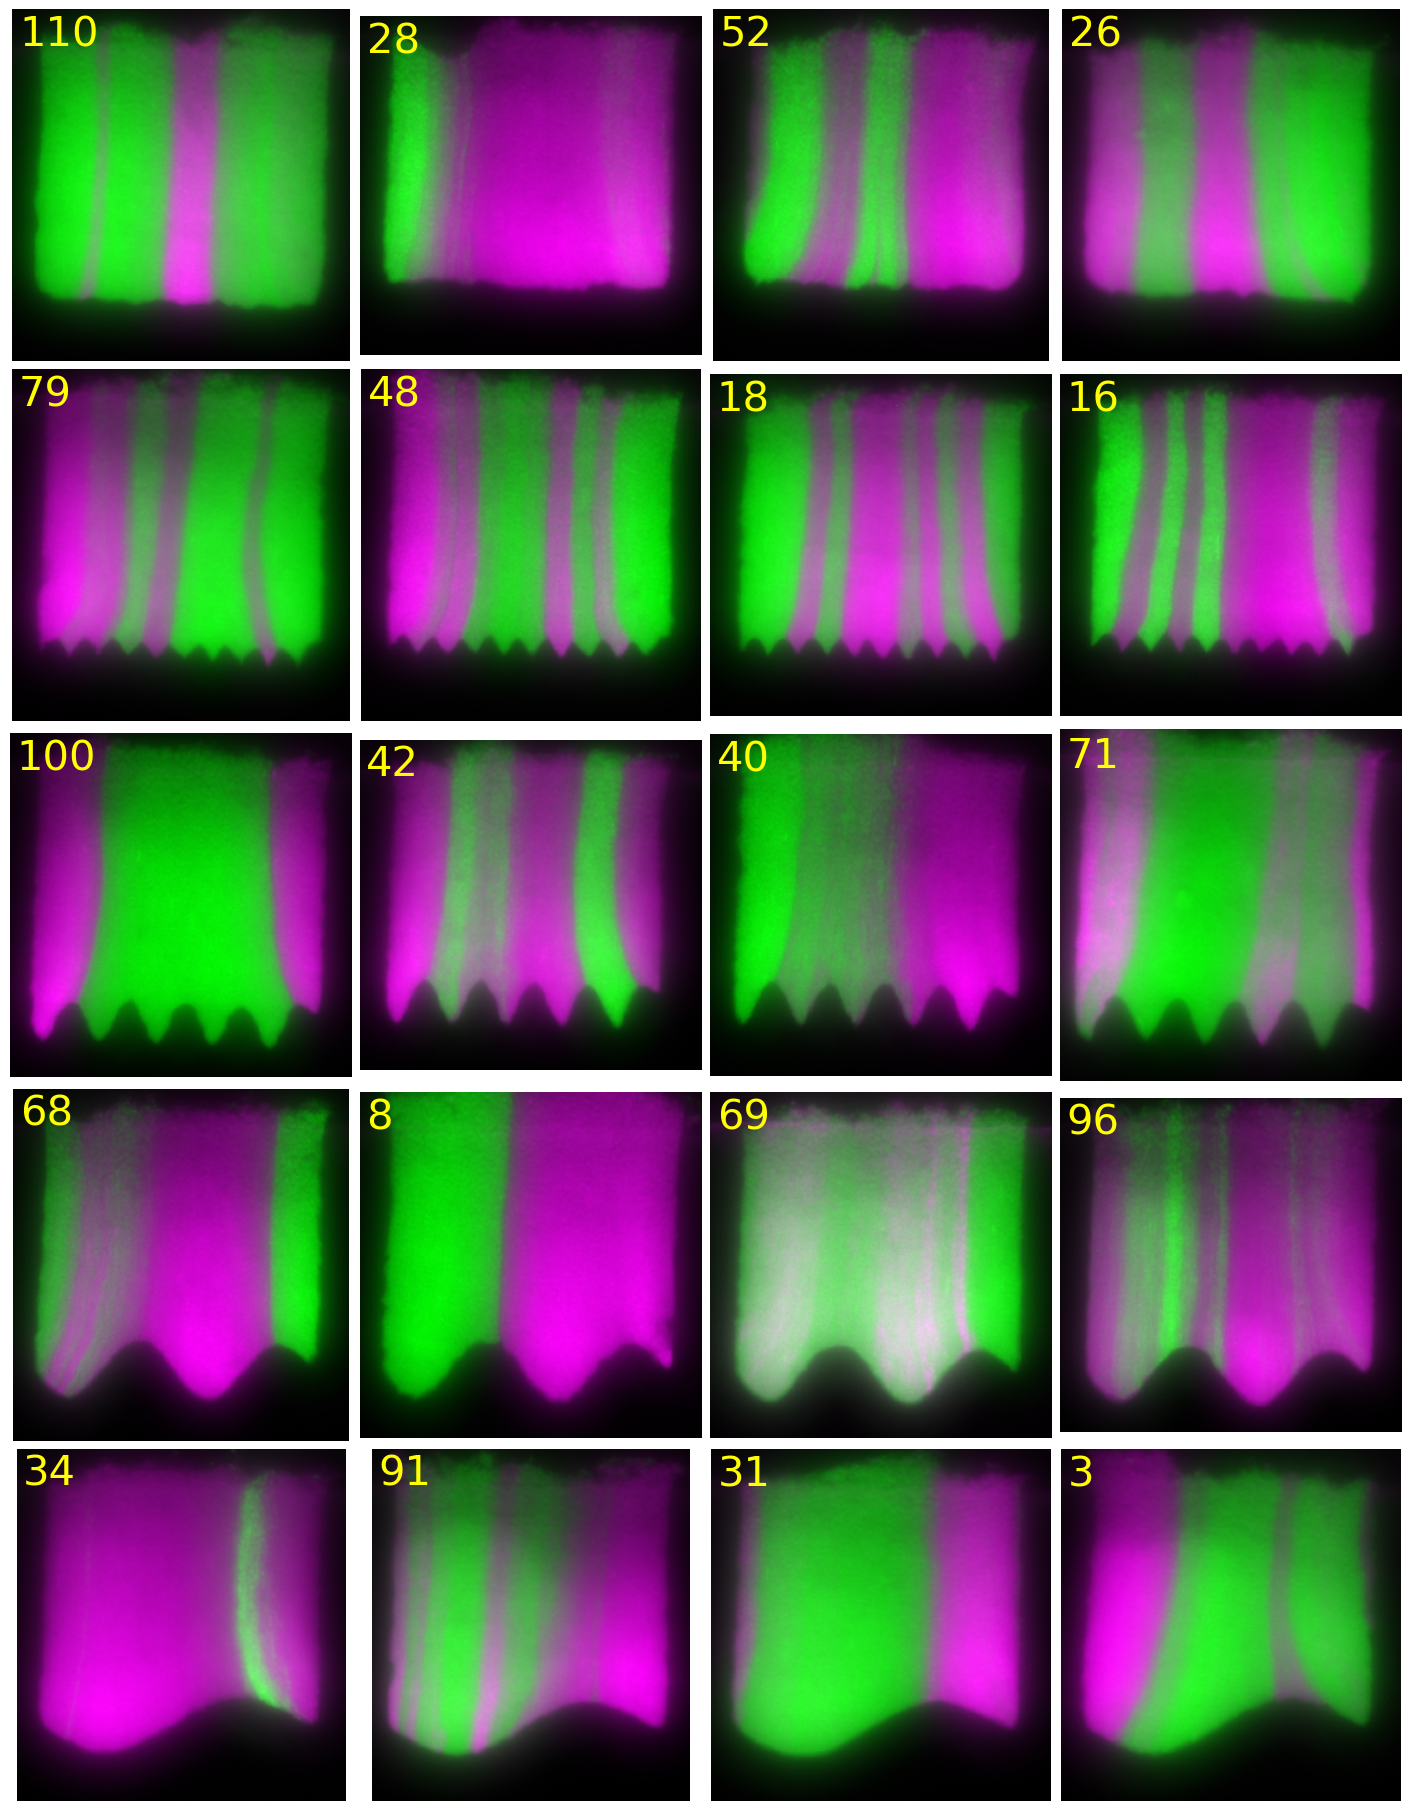

In [115]:
# this creates the actual figure

TA=np.concatenate((c1.flat[[30,  8, 12,  6]],c1.T10A20[[12,  8,  3,  1]],c1.T20A20[[15,  7,  5, 11]],c1.T50A20[[12,  3, 13, 15]],c1.T100A20[[9, 16,  6,  3]]))
n=len(TA)
fig = plt.figure(figsize=(14,3.6*int((n+3)//4)),constrained_layout=True)
fig.patch.set_facecolor('w')
ax_array = fig.subplots((n+3)//4, 4, squeeze=False)
for i in range(0,n):
    extract_image(int(TA[i,0]),TA[i,1],ax_array[i//4,i%4],flip_if_required=True)
for i in range(0,(n+3)//4):
    for j in range(0,4):
        ax_array[i,j].axis('off')
        ax_array[i,j].text(5,30,str(4*TA[4*i+j,0]+TA[4*i+j,1]),fontsize=30,color='yellow')
plt.show()

## Fig. 1D - positions of sector boundaries

In [7]:
typenames=['T100A20','T100A10','T50A20','T50A10','T20A20','T20A10','T10A20','T10A10','flat']
boundaries=[[0.25, 0.75],np.flip([0.25, 0.75]),[0.375, 0.5,0.125],np.flip([0.375, 0.5,0.125]),[0.15, 0.2, 0.2, 0.2, 0.2, 0.05],
            np.flip([0.15, 0.2, 0.2, 0.2, 0.2, 0.05]),[0.075, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.025],
            np.flip([0.075, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.025]),[]]
filenames=[['\\data_Fig_1\\experiment_'+str(i)+'\\prob_sector_boundaries_'+typenames[j] for i in range(1,4)] for j in range(0,9)]

In [8]:
# this function reads data files containing the probability p(x) of finding a sector boundary at a normalized position x=0..1
# across the well, and averaged over all wells of the same type

def peaks_inbetween_secs(filenames,xpos):
    
    xx=np.linspace(0,1,200)
    yy=np.full(200,0)
    for filename in filenames: 
        data = np.genfromtxt(currdir+filename+'.csv', delimiter=',')
        data[:,1]=data[:,1]/np.max(data[:,1])
        tck=interpolate.splrep(data[:,0],data[:,1])
        yy=yy+interpolate.splev(xx,tck)
    
    fig = plt.figure(figsize=(3,1.6),constrained_layout=True)
    ax = fig.subplots()
    fig.patch.set_facecolor('w')
    plt.plot(xx,yy)
    xs=np.cumsum(xpos[:-1])
    for x in xs:
        plt.axvline(x,color='black')
    plt.ylim(0)
    plt.savefig(currdir+filename+'.png',dpi=300)
    plt.show() 
    return xx,yy

<Figure size 640x480 with 0 Axes>

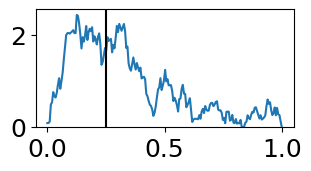

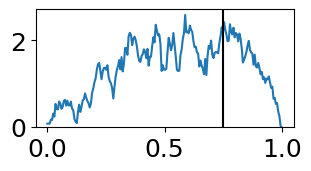

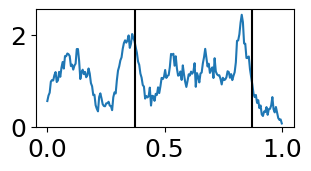

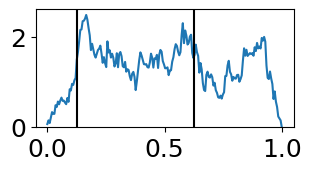

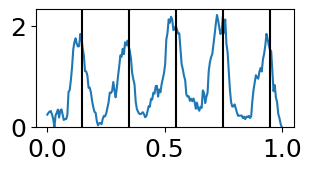

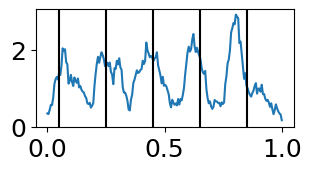

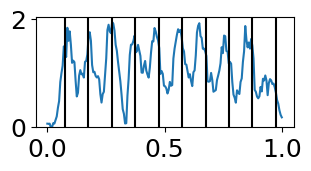

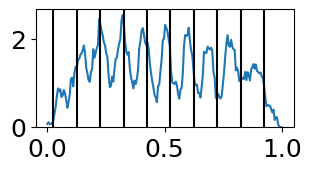

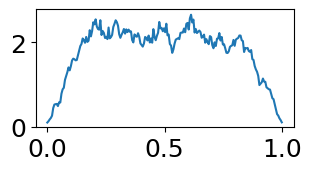

In [9]:
# this function generates all plots

plt.rcParams['font.size'] = '18'
plt.figure(facecolor='w')
probs=[peaks_inbetween_secs(filenames[j],boundaries[j]) for j in range(0,9)]
plt.rcParams['font.size'] = '12'

## Fig. S2

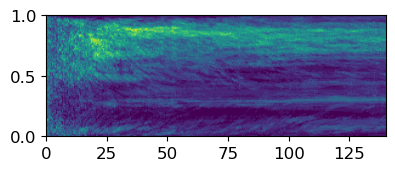

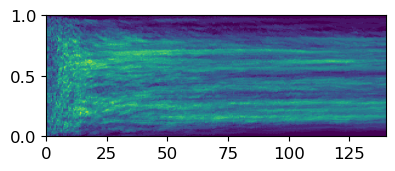

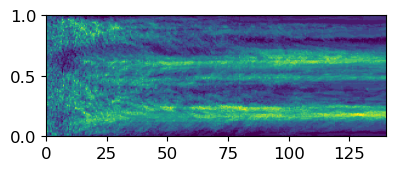

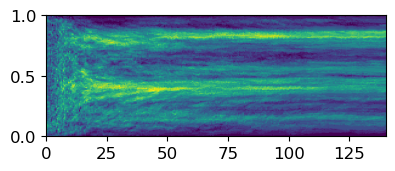

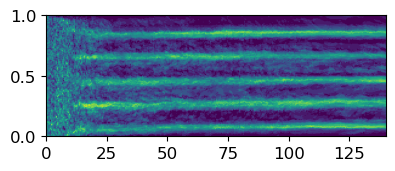

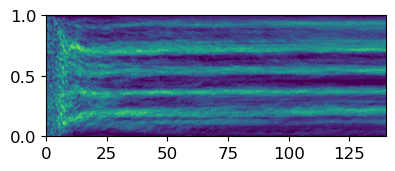

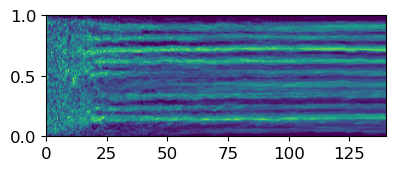

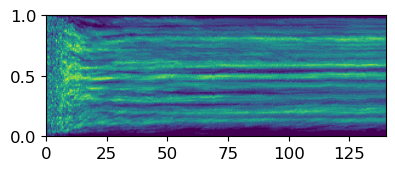

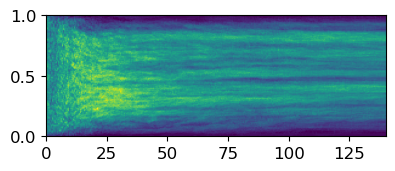

In [17]:
filenames=['\\data_Fig_1\\experiment_1\\timecourse_prob_sector_boundaries_'+typenames[j] for j in range(0,9)]

def peaks_inbetween_secs_time(fn):
    with open(currdir+fn+'.npb','rb') as f:
        aver=np.load(f)
    
    fig = plt.figure(figsize=(4,2),constrained_layout=True)
    ax = fig.subplots()
    fig.patch.set_facecolor('w')

    tmax=0.5*len(aver[0])
    plt.imshow(aver,aspect=50,extent=[0,tmax,0,1])
    plt.savefig(currdir+fn+'.png',dpi=300)
    plt.show()   

#plt.rcParams["figure.figsize"] = (5,3)
for j in range(0,9):
    peaks_inbetween_secs_time(filenames[j])

In [46]:
import matplotlib as mpl

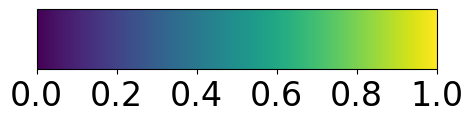

In [82]:
plt.rcParams['font.size'] = '24'
fig = plt.figure()
ax = fig.add_axes([0.1, 0.40, 0.8, 0.3])
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap='viridis', norm=mpl.colors.Normalize(0, 1),alpha=1)
plt.rcParams['font.size'] = '12'
plt.savefig(currdir+'\\data_Fig_1\\colorbar_viridis.png',dpi=300)

## Fig. S3 G

In [20]:
# a function for plotting the average over many replicate time series
def plot_av(data,qx=0.5,out_data=False,ax=None,skip=1,**plot_options):
    tmp=np.array(data)
    av=np.mean(tmp[:,::skip,1],axis=0)
    nsam=len(tmp[:,0,0])
    std=np.std(tmp[:,::skip,1],axis=0)/np.sqrt(nsam)
    if (out_data==True):
        return tmp[0,::skip,0]*qx,av,std
    else:
        if ax==None:
            plt.errorbar(tmp[0,::skip,0]*qx,av,std,**plot_options)
        else:
            ax.errorbar(tmp[0,::skip,0]*qx,av,std,**plot_options)

# helper functions for calculating sectors sizes from sector boundary positions
def secdiff(x):
    dx=np.diff(x)
    return dx/(x[-1]-x[0])

def avdiff(x):
    dx=np.diff(x)
    return np.mean(dx)/(x[-1]-x[0])


# a helper class for reading and processing data files
class SectorData:
    def __init__(self, name):
        file=open(name)
        print(file.readline())
        self.secs = [np.array(list(map(int, line.split(',')))) for line in file]
        file.close()
        self.secsizes=[np.concatenate((s[0:4],s[9:])) for s in self.secs]
        self.secs=np.array([s[0:9] for s in self.secs])
        print(self.secs[-1])
        print(self.secsizes[-1])
        self.tend=np.max(self.secs[:,1])
    
    def Psecspos(self,wells,thxpos,reversed=False): 
        tmp=[]
        for s in wells:
            pi,ni=s[0],s[1]
            tmp.append(np.concatenate([(xx[5:-1])/(xx[-1]-xx[4]) for xx in self.secsizes if xx[0]==pi and xx[3]==ni and xx[1]>self.tend-100]))
        tmp=np.concatenate(tmp)
        if reversed:
            tmp=1-tmp # flip positions of sector boundaries
        plt.hist(tmp,bins=50,density=True,alpha=0.5)
        xs=np.cumsum(thxpos[:-1])
        for x in xs:
            plt.axvline(x,color='black')
            
    def Psecsizeend(self,wells): #
        tmp=[]
        for s in wells:
            pi,ni=s[0],s[1]
            tmp.append(np.concatenate([secdiff(xx[4:]) for xx in self.secsizes if xx[0]==pi and xx[3]==ni and xx[1]==self.tend]))
        return np.concatenate(tmp)
    
    def avsecsize(self,wells):
        #pi,ti,zi,ni,xposs
        tmp=[]
        for s in wells:
            pi,ni=s[0],s[1]
            tmp.append([[xx[1],avdiff(xx[4:])] for xx in self.secsizes if xx[0]==pi and xx[3]==ni])
        return tmp
    def avsecsizeend(self,wells): 
        tmp=[]
        for s in wells:
            pi,ni=s[0],s[1]
            tmp.append([avdiff(xx[4:]) for xx in self.secsizes if xx[0]==pi and xx[3]==ni and xx[1]>self.tend-20])
        return np.mean(tmp), np.std(tmp)/np.sqrt(len(tmp))
    def avsecsizeendlist(self,wells): 
        tmp=[]
        for s in wells:
            pi,ni=s[0],s[1]
            tmp.append([avdiff(xx[4:]) for xx in self.secsizes if xx[0]==pi and xx[3]==ni and xx[1]==self.tend-1])
        return np.array(tmp)

In [19]:
# read the files and process to extract the positions of sector boundaries

s1=SectorData(currdir+'\\data_Fig_1\\experiment_1\\sectors_2023_11_14_rev_fig1_v2_5_bottom.csv')
s2=SectorData(currdir+'\\data_Fig_1\\experiment_2\\sectors_2024_01_18_rev_fig1_v2_5_bottom.csv')
s3=SectorData(currdir+'\\data_Fig_1\\experiment_3\\sectors_2024_01_26_rev_fig1_v2_5_bottom.csv')

ss=[s1,s2,s3]
cc=[c1,c2,c3]

pi,ti,zi,ni,n1,n2,ns1,ns2,Nsecs,xpos

[ 59 286   0   3  20 203   2   2   4]
[ 59 286   0   3   0   7 167 179 222]
pi,ti,zi,ni,n1,n2,ns1,ns2,Nsecs,xpos

[ 79 200   0   2 226  62   1   1   2]
[ 79 200   0   2   0  61 287]
pi,ti,zi,ni,n1,n2,ns1,ns2,Nsecs,xpos

[ 79 180   0   2 151 143   4   4   8]
[ 79 180   0   2   0  58 158 190 214 259 283 290 293]


<Figure size 270x800 with 0 Axes>

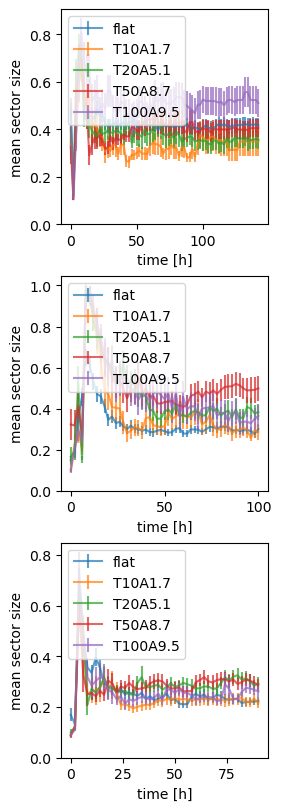

In [21]:
plt.rcParams["figure.figsize"] = (2.7,8)
plt.rcParams['font.size'] = '10'

plt.figure(facecolor='w')
fig,ax=plt.subplots(3,1,constrained_layout=True)
fig.patch.set_facecolor('w')

for i in range(0,3):
    c,s=cc[i],ss[i]
    TAs=[c.flat,c.T10A20,c.T20A20,c.T50A20,c.T100A20]
    for TA in TAs:
        plot_av(s.avsecsize(TA),ax=ax[i],skip=4,alpha=0.7)
    ax[i].legend(('flat','T10A1.7','T20A5.1','T50A8.7','T100A9.5'),loc='upper left')
    ax[i].set_xlabel("time [h]"); 
    #if (i==0):
    ax[i].set_ylabel("mean sector size")
    ax[i].set_ylim(bottom=0)

fig.savefig(currdir+'\\data_Fig_1\\aver_sector_size_time.png',dpi=300)
plt.show()

## Fig. S3 A

In [22]:
# data-preprocessing for the average sector size at the end of the experiment
# data[x][i] = average sector size in well of type x (x=0...8 represent differents T,A) and i-th replicate 
# (3 biological replicates x 20...80 technical replicates in the same chip)
data=[[] for i in range(0,9)]
for wi in range(0,9):
    for i in range(0,3):
        data[wi].append(ss[i].avsecsizeendlist(cc[i].TAs[wi]))
    data[wi]=np.ravel(np.concatenate(data[wi]))


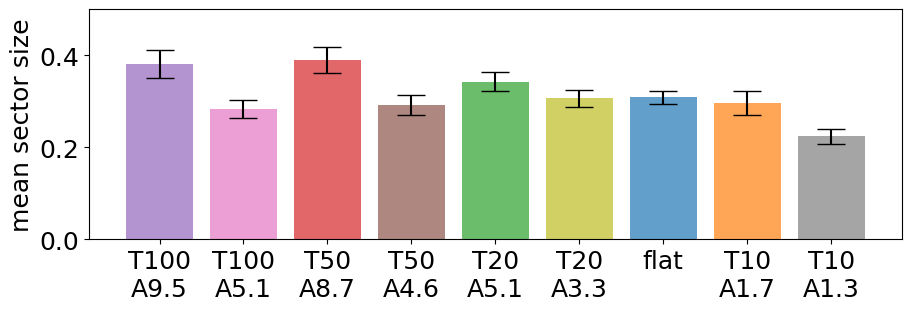

<Figure size 270x800 with 0 Axes>

In [25]:
plt.rcParams['font.size'] = '18'
fig,ax=plt.subplots(figsize=(9,3),constrained_layout=True)
fig.patch.set_facecolor('w')
x_pos=[0,1,2,3,4,5,6,7,8]
cols=['tab:purple','tab:pink','tab:red','tab:brown','tab:green','tab:olive','tab:blue','tab:orange','tab:grey']
ax.set_xticks(x_pos)
ax.set_xticklabels(["T100\nA9.5","T100\nA5.1","T50\nA8.7","T50\nA4.6","T20\nA5.1","T20\nA3.3","flat","T10\nA1.7","T10\nA1.3"])
ax.set_ylabel('mean sector size')
plt.figure(facecolor='w')
ax.bar(x_pos,[np.mean(data[x]) for x in x_pos],yerr=[np.std(data[x])/np.sqrt(len(data[x])) for x in x_pos],align='center', alpha=0.7,ecolor='black', capsize=10, color=cols)
ax.set_ylim(0,0.5)
#ax.errorbar(x_pos,[np.mean(data[x]) for x in x_pos],yerr=[np.std(data[x])/np.sqrt(len(data[x])) for x in x_pos],ecolor='black', capsize=10)
fig.savefig(currdir+'\\data_Fig_1\\mean_sector_sizes.png',dpi=300)
plt.show()
plt.rcParams['font.size'] = '14'

## Fig. S3 B

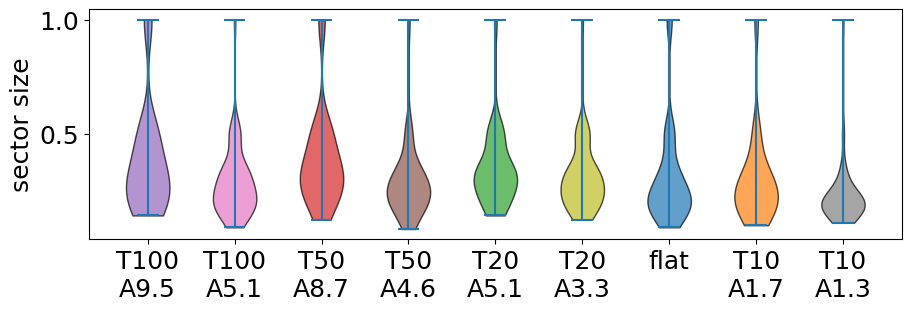

<Figure size 270x800 with 0 Axes>

In [26]:
plt.rcParams['font.size'] = '18'
fig,ax=plt.subplots(figsize=(9,3),constrained_layout=True)
fig.patch.set_facecolor('w')
x_pos=[0,1,2,3,4,5,6,7,8]
ax.set_xticks(x_pos)
ax.set_xticklabels(["T100\nA9.5","T100\nA5.1","T50\nA8.7","T50\nA4.6","T20\nA5.1","T20\nA3.3","flat","T10\nA1.7","T10\nA1.3"])
ax.set_ylabel('sector size')
plt.figure(facecolor='w')
parts=ax.violinplot(data,positions=x_pos)
i=0
for pc in parts['bodies']:
    pc.set_facecolor(cols[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    i=i+1
#ax.errorbar(x_pos,[np.mean(data[x]) for x in x_pos],yerr=[np.std(data[x])/np.sqrt(len(data[x])) for x in x_pos],ecolor='black', capsize=20,linestyle='none')
fig.savefig(currdir+'\\data_Fig_1\\mean_sector_size_violin_plots.png',dpi=300)
plt.show()
plt.rcParams['font.size'] = '14'

In [27]:
# p-values for the KS test comparing different distributions from the plot above with the flat-well distribution
[np.round(ks_2samp((data[x]),(data[6]))[1],4) for x in x_pos]

[0.0107, 0.9868, 0.0001, 0.2787, 0.0005, 0.0557, 1.0, 0.9254, 0.0024]

* = p<0.05
** = p<0.01
*** = p<0.001

## Fig. S4 B - heterozygocity

In [39]:
# this function reads in files prepared by the H_vs_time(filename,pi) function run separately for each of the three replicates
def read_Hs_file(filename):
    hhs=[]
    with open(filename,'rb') as f:
        for i in range(0,9):
            hhs.append(np.load(f))
    return hhs
names=['experiment_1\\Hs_2023_11_14.npy','experiment_2\\Hs_2024_01_18.npy','experiment_3\\Hs_2024_01_26.npy']
hhs=[read_Hs_file(currdir+'\\data_Fig_1\\'+fn) for fn in names]

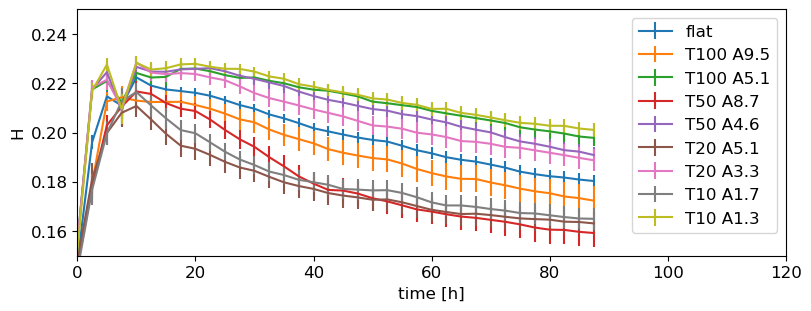

In [40]:
fig,ax=plt.subplots(figsize=(8,3),constrained_layout=True)
fig.patch.set_facecolor('w')
plt.rcParams['font.size'] = '12'
for i in range(0,9):        
    tmp=np.concatenate((hhs[0][i][:,0:36],hhs[1][i][:,0:36],hhs[2][i][:,0:36]))
    tt,yy,err=plot_av(tmp,qx=0.5,out_data=True)
    plt.errorbar(tt,yy,err) #,c=cols[i]) #,c=(1-i/9,0,i/9))
ax.legend(('flat','T100 A9.5','T100 A5.1','T50 A8.7','T50 A4.6','T20 A5.1','T20 A3.3','T10 A1.7','T10 A1.3'),loc='upper right')
ax.set_ylim(0.15,0.25)
ax.set_xlim(0,120)
ax.set_ylabel('H')
ax.set_xlabel('time [h]')
fig.savefig(currdir+'\\data_Fig_1\\heterozygocity.png',dpi=300)

plt.show()